# Analyzing Salinity Patterns in South Florida Using EnviStor + PelicanFS

This notebook demonstrates how to analyze salinity patterns in South Florida using curated buoy data processed by the **EnviStor smart data pipeline** and made available through **PelicanFS**, a high-performance file system interface for the Open Science Data Federation (OSDF).

The data used here comes from three monitoring stations managed by FIU, each located in a distinct part of South Florida’s coastal waters. These datasets were curated and made analysis-ready by the EnviStor pipeline.

The central question is: 
> **What are the salinity patterns in South Florida?**

We'll answer this by loading the data, cleaning and merging it, and visualizing salinity trends over time across multiple locations.

---

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pelicanfs.core import OSDFFileSystem
from io import BytesIO

sns.set(style="whitegrid")

## Load the Curated Salinity Datasets

We’ll load data from three buoy stations directly from PelicanFS using the `OSDFFileSystem()` interface. These Excel files have already been curated and prepared by the EnviStor smart pipeline, and are stored in the `/envistor` namespace in OSDF.

Each file corresponds to a different buoy location:
- **Biscayne Bay**
- **Haulover Inlet**
- **Little River**

We use `BytesIO` to read the content as a stream before passing it to `pandas.read_excel()`. Each resulting DataFrame includes a `"Station"` column to identify its source location.

In [2]:
pelfs = OSDFFileSystem()
file_buoy1 = pelfs.cat('/envistor/CREST_Buoy_2_NW_Biscayne_Bay_-_S_of_Biscayne_Canal_082720-112221.xlsx')
file_buoy2 = pelfs.cat('/envistor/CREST_Buoy_3_Haulover_Inlet_100518_-_073020_updated.xlsx')
file_buoy3 = pelfs.cat('/envistor/CREST_Buoy_3-2_Little_River_042121-050624.xlsx')

excel_file1 = BytesIO(file_buoy1)
df_file_buoy1 = pd.read_excel(excel_file1)
df_file_buoy1['Station'] = 'Buoy - Biscayne Bay'

excel_file2 = BytesIO(file_buoy2)
df_file_buoy2 = pd.read_excel(excel_file2)
df_file_buoy2['Station'] = 'Buoy - Haulover Inlet'

excel_file3 = BytesIO(file_buoy3)
df_file_buoy3 = pd.read_excel(excel_file3)
df_file_buoy3['Station'] = 'Little River'


## Clean and Combine the Data

Now that we’ve loaded the individual DataFrames, we’ll prepare them for analysis.

Here’s what we do:
1. **Create a timestamp**: Combine the `"Date"` and `"Time"` columns into a single `datetime` column.
2. **Standardize salinity**: Rename the `"Sal_psu"` column to `"Salinity"` and convert its values to numeric (in case of string or error-prone entries).
3. **Merge datasets**: Concatenate the three cleaned DataFrames into one (`df_all`) so we can analyze salinity trends across all buoy stations together. We also drop any rows with missing salinity values and set the `datetime` column as the index to enable time-based operations later.


In [3]:
for df in [df_file_buoy1, df_file_buoy2, df_file_buoy3]:
    df["datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str))

    df.rename(columns={"Sal_psu": "Salinity"}, inplace=True)
    df["Salinity"] = pd.to_numeric(df["Salinity"], errors="coerce")

df_all = pd.concat([df_file_buoy1, df_file_buoy2, df_file_buoy3], ignore_index=True)
df_all.dropna(subset=["Salinity"], inplace=True)
df_all.set_index("datetime", inplace=True)


## Resample and Aggregate

Salinity readings are taken multiple times per day. To reveal broader trends, we resample the data to **daily averages**.

This step:
- Reduces noise
- Makes it easier to compare across time
- Prepares the data for visualization

We group by station and resample by day (`'1D'`).


In [4]:
df_daily = (
    df_all
    .groupby("Station")
    .resample("1D")
    ["Salinity"]
    .mean()
    .reset_index()
)


## Visualize the Salinity Patterns

Now we can plot daily salinity patterns to compare how they evolve over time across the three locations.

We’ll use Seaborn for a clean, readable line chart.


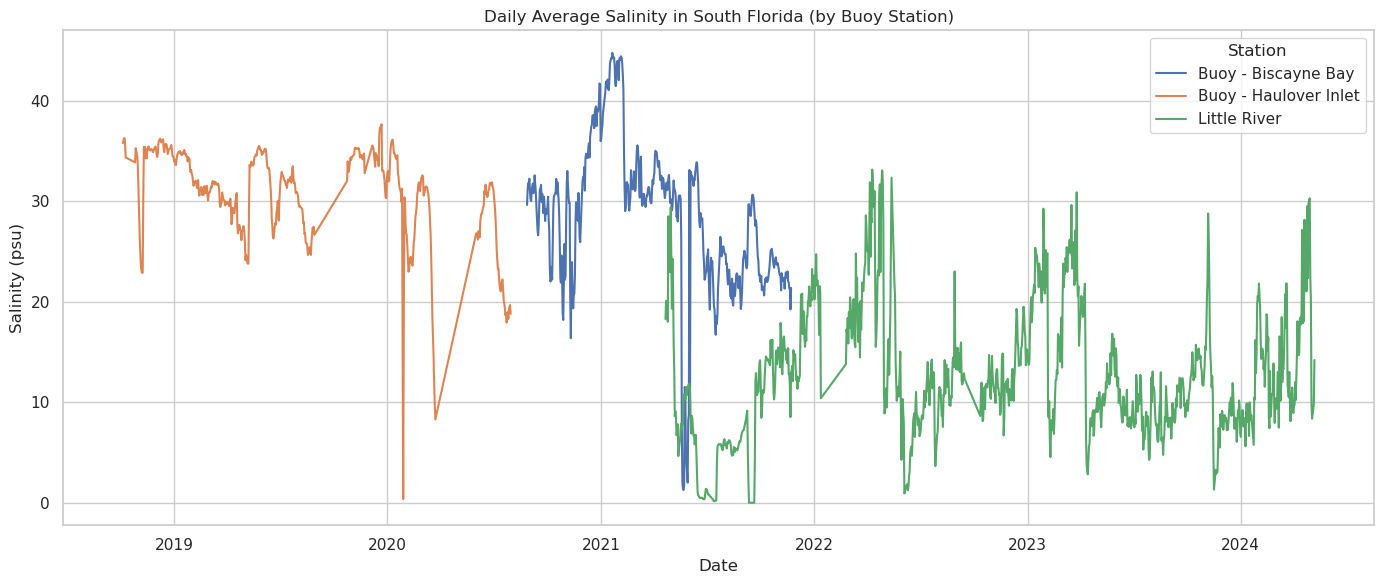

In [5]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_daily, x="datetime", y="Salinity", hue="Station")
plt.title("Daily Average Salinity in South Florida (by Buoy Station)")
plt.xlabel("Date")
plt.ylabel("Salinity (psu)")
plt.legend(title="Station")
plt.tight_layout()
plt.show()


```{note}
💡 **Why this is possible**

This visualization is only possible thanks to the **EnviStor Smart Pipeline**, which curated, cleaned, and enriched the buoy data, and published it to OSDF.

Additionally, the **Pelican platform** allowed us to access the data on-demand using `PelicanFS` — no local downloads or manual data wrangling required. This is a great example of how data infrastructure can directly support scientific insight.


## Interpret the Results

With the visualization in hand, we can start identifying key salinity patterns in South Florida:

- **Biscayne Bay** (blue) shows a clear **seasonal fluctuation**, with higher salinity in dry months and noticeable drops likely linked to storm events or freshwater inflow.
- **Haulover Inlet** (orange) tends to have **consistently higher salinity** levels, suggesting stronger tidal mixing and less influence from freshwater discharge.
- **Little River** (green) displays **the most variability** — sharp dips and spikes in salinity hint at frequent freshwater input, possibly from canals, rain events, or upstream runoff.

These differences illustrate how **geographic location and local hydrology** impact salinity levels. By comparing trends across stations, we gain insight into how dynamic and localized coastal salinity can be.

```{note}
This type of analysis can support environmental monitoring, resource management, and research on saltwater intrusion and estuarine health.


## Next Steps

This notebook provided a foundation for analyzing coastal salinity patterns using curated data from the EnviStor pipeline. If you're interested in extending this work, here are a few ideas:

- **Incorporate other environmental variables**: Analyze how temperature, turbidity, or dissolved oxygen vary alongside salinity to build a more holistic view of water quality.
- **Add spatial analysis**: Use GIS tools or libraries (e.g., Cartopy or Folium) to visualize station locations and explore spatial gradients in salinity.
- **Compare across years**: Investigate long-term salinity trends and identify anomalies across different seasons or years.
- **Include other datasets from EnviStor**: Expand the workflow by pulling additional datasets from OSDF, such as ocean currents, rainfall, or metadata-enriched observations.
- **Develop alert thresholds**: Identify salinity levels that may signal ecological stress or risk, potentially integrating this with decision-making tools.

```{hint}
Curious about how the data got so clean? Check out the [EnviStor smart pipeline’s](https://envistorhome.fiu.edu/envistor/) role in preparing these files — from metadata tagging to anomaly filtering — to better understand the power of backend automation.
